# Simultaneous optimization in observational threshold and time, breaking observers into cycle-long intervals

Andrés Muñoz-Jaramillo, Laure Lefevre, & Ilya Usoskin


## Objective and Conclusions

The goal of this notebook is to account for the randomness of cycle progression by breaking observers into chunks and letting those chunks float independently during optimization.

Each chunk is callibrated to the reference using a running window of the same size, coupled with the removal of missing days using masking, gives a better result while finding thresholds.
    

## Things to Play With

* The observer that will be compared with the reference is specified in the cell below [**"Processing observer"**](#observer) in the variable _CalObs_


## Other Parameters

* The duration of the calibration "month" is specified in the cell below [**"Recasting observations into equal intervals of specified duration"**](#duration) in the variable _MoLngt_
* The minimum percentage of observations a "month" must have is specified in the cell below [**Distributions of active day fractions and observed day fractions for given observer**](#coverage)
* The optimization parameters (temporal stride, number of thresholds, and threshold increments) are specified in the cell below [**"Calculating active number of active and observed days"**](#parameters)

# Modules, colors, and functions

In [1]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy
%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 17}

plt.rc('font', **font)


# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading Reference data

We use a reduced version of the RGO and Debrecen data as provided by the [Heliophysical Observatory, Debrecen
](http://fenyi.solarobs.csfk.mta.hu/en/databases/GPR/).  Supplemented during cycle 24 with observations by the [Kidslovodsk Mountain Astronomical Station](http://dx.doi.org/10.7910/DVN/M7NDXN).  It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add two more columns to the data:
    1. ORDINAL:  number of days after (0001,01,01).
    2. FRACYEAR: Fractional year for plotting.

In [2]:
#REF_Dat = pd.read_csv('input_data/DRGO_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
REF_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)

REF_Dat['ORDINAL'] = REF_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
REF_Dat['FRACYEAR'] = REF_Dat.apply(lambda x: x['YEAR'].astype(int)
                                            + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                  ,axis=1)

# Turning reference areas into number of groups
REF_Grp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
REF_Grp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1)
REF_Grp['GROUPS'] = REF_Grp['GROUPS'].astype(float)
REF_Grp.loc[np.isnan(REF_Dat['AREA1']), 'GROUPS'] = np.nan

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
REF_Grp['AVGROUPS']  = conv.convolve(REF_Grp['GROUPS'].values,Gss_1D_ker)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


# Reading SILSO's total sunspot number

We use the current series to separate individual cycles from minimum to minimum.  We also identify all the minima present in the reference data, removing the first two minima to isolate potential drifts and systematic errors during the beginning of the RGO era.

In [3]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)

# Smoothing

swin = 8 #Smoothing window in months
window = signal.gaussian(M=swin*6, std=swin)
window /= window.sum()

SILSO_Sn['MSMOOTH'] = np.convolve(SILSO_Sn['MMEAN'], window, mode='same')

# Finding maxima and minima
pkMax = detect_peaks(SILSO_Sn['MSMOOTH'], mpd=5)
pkMin = detect_peaks(-SILSO_Sn['MSMOOTH'], mpd=5)

SIL_max = SILSO_Sn.loc[pkMax, 'MSMOOTH'].values
SIL_maxT = SILSO_Sn.loc[pkMax, 'FRACYEAR'].values

SIL_min = SILSO_Sn.loc[pkMin, 'MSMOOTH'].values
SIL_minT = SILSO_Sn.loc[pkMin, 'FRACYEAR'].values

# Setting aside minima covered by the reference data
REF_min = SIL_min[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
REF_minT = SIL_minT[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]

# # Remove first two minima
# REF_min = REF_min[2:REF_min.shape[0]]
# REF_minT = REF_minT[2:REF_minT.shape[0]]

# # Remove last minimum
# REF_min = REF_min[0:REF_min.shape[0]-1]
# REF_minT = REF_minT[0:REF_minT.shape[0]-1]

# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

In [4]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1-12.csv', quotechar = '"', encoding = 'ansi',header = 15)

We add two more columns to the data:
    1. ORDINAL:  number of days after (0001,01,01).
    2. FRACYEAR: Fractional year for plotting.
    
and recast the number of groups as a float so that we can use NaNs for days with missing observations.

In [5]:
GN_Dat['ORDINAL'] = GN_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
GN_Dat['FRACYEAR'] = GN_Dat.apply(lambda x: x['YEAR'].astype(int)
                                            + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                  ,axis=1)

GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)

## Reading observers

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

The **_print_** statement on this cell can be use for reference as it shows the station number associated with each observer.

In [6]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1-12.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     INITIAL   FINAL  STATION                                   OBSERVER  TOT.OBS
0     1610.0  1613.0        1                        HARRIOT, T., OXFORD      210
1     1611.0  1640.0        2                         SCHEINER, C., ROME      882
2     1612.0  1612.0        3                          GALILEO, G., ROME       51
3     1612.0  1612.0        4                      GALILEO/SAKURAI, ROME       37
4     1612.0  1612.0        5                      COLOGNA, S., MONREALE       20
5     1612.0  1613.0        6                       JUNGIUS, J., HAMBURG      104
6     1612.0  1612.0        7                         CIGOLI, L.C., ROME       29
7     1613.0  1614.0        8                        COLONNA, F., NAPLES       51
8     1615.0  1617.0        9                          TARDE, J., FARLAT       69
9     1616.0  1616.0       10                    SAXONIUS, P., NUREMBERG       12
10       NaN     NaN       11                      MARIUS, S., NUREMBERG        0
11    1618.0  16

<a id='observer'></a>
# Processing observer

This cell picks the observer that will be calibrated to REF.  Some interesting observers are:

* Spörer: 318 (lots of missing zeros)
* Leppig: 324 (short and consistent, but with lots of missing days)
* Wolfer: 338 (long and dense)

It is interesting to see if the time optimization can get the proper time accurately.  Some observers that do:

* Moye: 412 (1 cycle)
* Broger: 370 (4 cycles)

Some that don't

* Woinoff: 376 (2 cycles, very strong yearly variation)

Other long observers with overlap are:

* Sykora: 366
* Guillaume: 386
* Stempell: 389 (lots of gaps)
* Koyama: 445
* National astron. ob. Japan: 447

Observations for the chosen observer are filled with NaNs for days without observations.


In [7]:
# Observer Station Number
CalObs = 318
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

#print(NamObs)

# Picking observations
ObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(ObsDat['ORDINAL']), np.max(ObsDat['ORDINAL']+1))
MisDays =  np.logical_not(sp.in1d(ObsInt, ObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+ObsDat.iloc[0,4]
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, station, observer, groups, ObsInt[MisDays], fractyear)), columns = ObsDat.columns.values)

# Append dataframe with missing days
ObsDat = ObsDat.append(NoObs,ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
ObsDat = ObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
ObsDat = ObsDat.sort_values('ORDINAL').reset_index(drop=True)

#print(ObsDat.to_string())

<a id='duration'></a>
## Recasting observations into equal intervals of specified duration


To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [8]:
# Number of days per "month"
MoLngt = 30

# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:np.int(grpsOb.shape[0]/MoLngt)*MoLngt]

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:np.int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:np.int(yrOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))

## Calculating number of days with observations and number of days with groups 

In [9]:
# OBSERVER
# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker)
SdGrpOb = np.nanstd(grpsOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<a id='#subintervals'></a>
## Breaking Observer Period into Max-to-Max Intervals

We break the observational period into cycles going from maximum to maximum in order to ease the capability of the algorithm to find the best matches during the reference era.

In [10]:
# Finding internal endpoints and centers
endPoints = SIL_maxT[np.logical_and(SIL_maxT>np.min(yrOb), SIL_maxT<np.max(yrOb)).nonzero()]
cenPoints = SIL_minT[np.logical_and(SIL_minT>np.min(yrOb), SIL_minT<np.max(yrOb)).nonzero()]
  
# Extending the smaller (left) end
# Looking for closest min
tmpMin = SIL_minT - np.min(yrOb)
tmpMin = tmpMin[tmpMin<0]
tmpMin = tmpMin[np.absolute(tmpMin) == np.min(np.absolute(tmpMin))]

# Looking for closest max
tmpMax = SIL_maxT - np.min(yrOb)
tmpMax = tmpMax[tmpMax<0]
tmpMax = tmpMax[np.absolute(tmpMax) == np.min(np.absolute(tmpMax))]

# Add the year if it is a minimum
if (np.absolute(tmpMin)<np.absolute(tmpMax)):
    # Extend interval
    endPoints[0]=tmpMin+np.min(yrOb)  
else:
    # Add interval
    endPoints=np.concatenate((tmpMax+np.min(yrOb), endPoints))       

# Extending the larger (right) end
# Looking for closest max
tmpMin = SIL_minT - np.max(yrOb)
tmpMin = tmpMin[tmpMin>0]
tmpMin = tmpMin[np.absolute(tmpMin) == np.min(np.absolute(tmpMin))]

# Looking for closest min
tmpMax = SIL_maxT - np.max(yrOb)
tmpMax = tmpMax[tmpMax>0]
tmpMax = tmpMax[np.absolute(tmpMax) == np.min(np.absolute(tmpMax))]

# Add the year if it is a minimum
if (np.absolute(tmpMin)<np.absolute(tmpMax)):
    # Extend interval
    endPoints[endPoints.shape[0]-1]=tmpMin+np.max(yrOb)   
else:
    # Add interval
    endPoints=np.append(endPoints,tmpMax+np.max(yrOb))
    
print('End points (minima or maxima):', endPoints)
print('Center points (minima):',cenPoints)

End points (minima or maxima): [ 1860.29   1870.874  1883.958  1901.707]
Center points (minima): [ 1867.204  1878.707  1889.455]


## Plotting comparison the observer's active vs. observed days per month

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


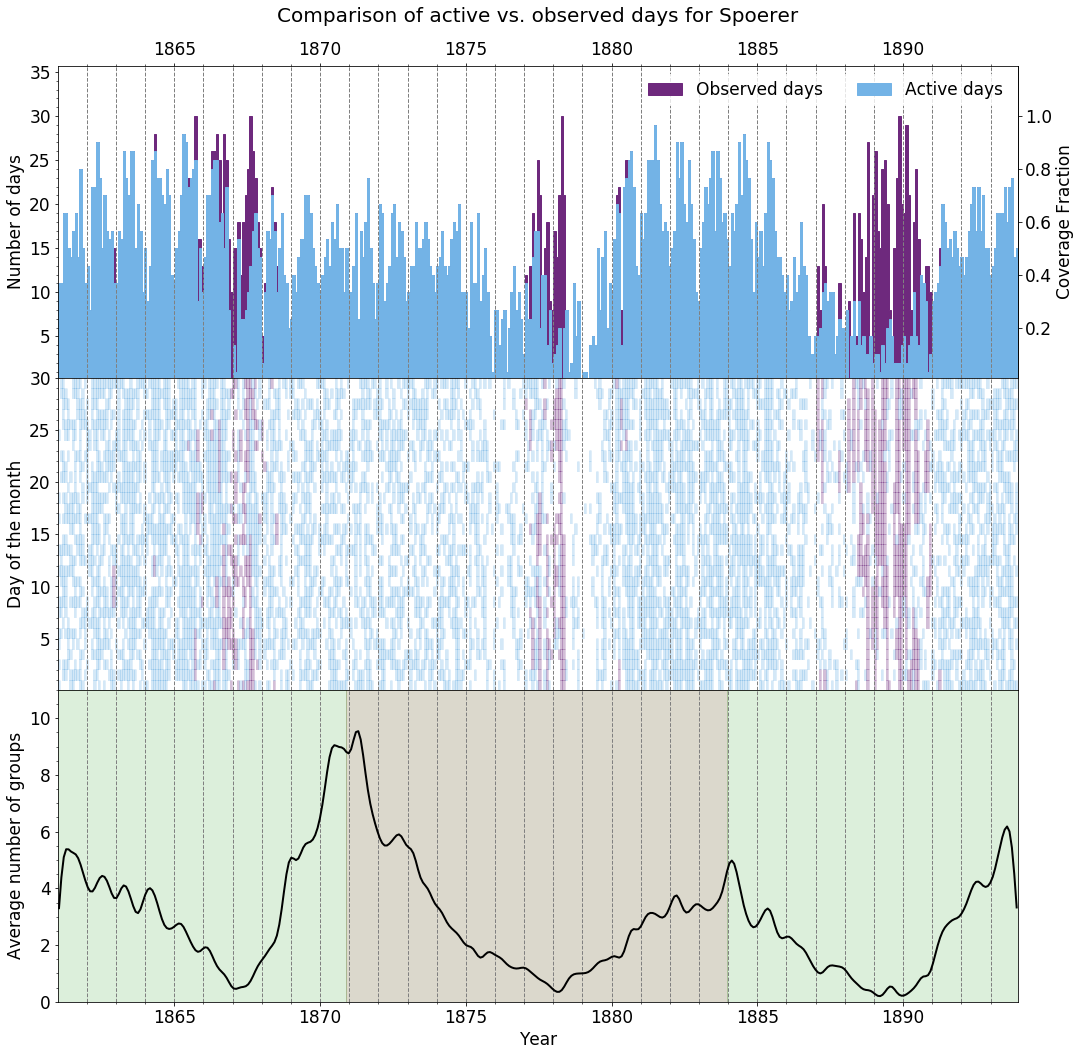

In [11]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltxOb = np.append(pltxOb,np.max(fyr2Ob))
pltxOb = np.append(pltxOb,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAvOb = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAvOb = np.insert(pltyAvOb,0,0)
pltyAvOb = np.append(pltyAvOb,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)



# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltxOb, pltyOb, color = Clr[2])
ax1.fill(pltxOb, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

for Idx in range(1,endPoints.shape[0]):
    ax3.fill([endPoints[Idx-1], endPoints[Idx-1], endPoints[Idx], endPoints[Idx]], [0, np.ceil(np.max(AvGrpOb))+1, np.ceil(np.max(AvGrpOb))+1, 0 ], color = Clr[1+np.mod(Idx,2)*2], alpha = 0.2)
#ax3.fill(pltxOb, pltyAvOb+pltySd, color = '0.8')
#ax3.fill(pltxOb, pltyAvOb-pltySd, color = 'w')
ax3.plot((fyr1Ob+fyr2Ob)/2, AvGrpOb, color = Clr[0], linewidth = 2)



# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0, top = np.ceil(np.max(AvGrpOb))+1);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.  Shaded areas indicate the separation of observations in sub-domains roughly going from maximum to maximum.

## Calculating the solar minimum masks that will be used in the optimization scan for best match

Given that our objective is to calculate the relative of different cycles we can take advantage of our knowledge of cycle progression to narrow the search for an optimum.  To do this we create a mask of valid search periods determined by using a window centered on the minima contained within the reference data.

In [12]:
# Cycle phase tolerance in years
phTol = 3

# Temporal Stride in days
dt = 90

#Creating window mask
minMask = np.zeros(REF_Grp.shape[0], dtype=bool)

# Applying mask
for minT in REF_minT:
    minMask[np.logical_and(REF_Grp['FRACYEAR'].values>=minT-phTol,REF_Grp['FRACYEAR'].values<=minT+phTol)] = True
    
# Creating cadence mask
cadMask = np.zeros(REF_Grp.shape[0], dtype=bool)
cadMask[range(0,cadMask.shape[0],dt)] = True

#  Appling cadence mask
cadMask = np.logical_and(cadMask,minMask)

# Turning Mask into indices
cadMaskI = np.array(cadMask.nonzero()[0])

## Plotting maxima, minima, and search windows

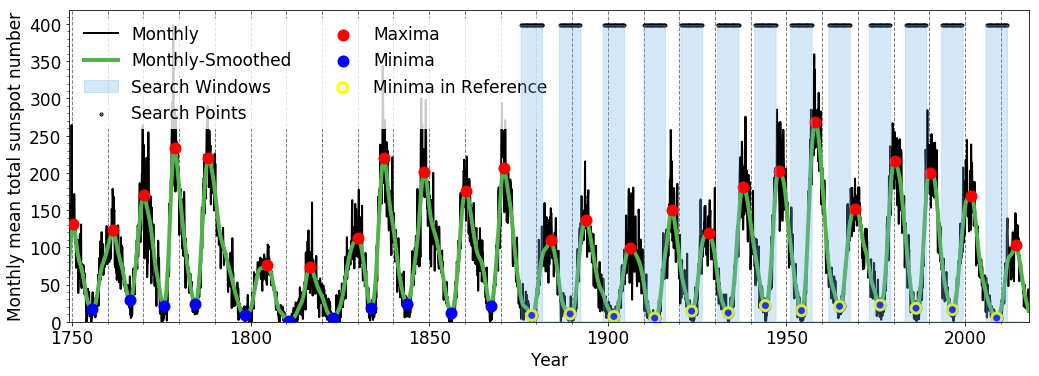

In [13]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2)
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 4)
ax1.scatter(REF_Grp['FRACYEAR'].values[cadMaskI], minMask[cadMaskI]*np.max(SILSO_Sn['MMEAN']), color='k', edgecolor='k', s=1, linewidths = 3, zorder=11)
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10)
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10)
ax1.scatter(REF_minT, REF_min, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10)
ax1.fill(REF_Grp['FRACYEAR'],  minMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[4], color = Clr[4], alpha = 0.3, zorder=15)


ax1.legend(['Monthly','Monthly-Smoothed','Search Windows', 'Search Points','Maxima', 'Minima','Minima in Reference'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.  Shaded areas indicate the separation of observations in sub-domains roughly going from maximum to maximum.

<a id='coverage'></a>
## Distributions of active day fractions and observed day fractions for given observer

The active day fraction method identifies the detection threshold of a given observer by identifying the closest cumulative distribution function observed in the reference data after applying varying thresholds.  The concern is that focusing on the active day fraction only, without looking at the observed day fraction, may yield erroneous thresholds.  The distributions for the given observer look like this:

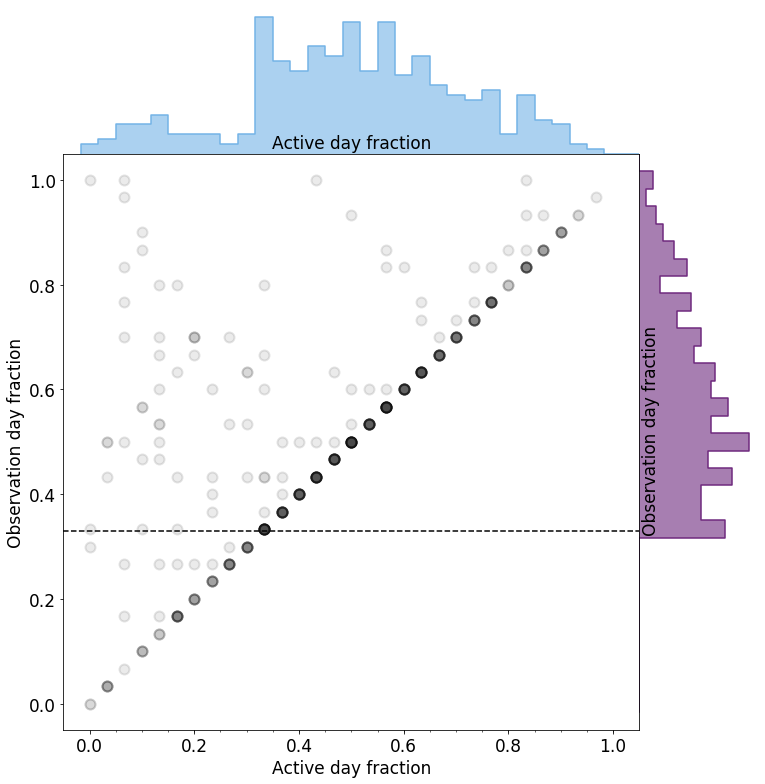

In [14]:
# Distribution Plots for Observer

# Minimum fraction of observed days
minObD = 0.33;

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
ax1 = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
ADFObs, bins, patches = ax1.hist(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[4], alpha=.6, normed = True);
(xAD, yAD) = histOutline(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, normed = True)
ax1.plot(xAD, yAD, color=Clr[4])

# Axes properties
ax1.set_xlim(left = -0.05, right = 1.05);
ax1.set_axis_off()


# Right Distribution
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
ax2.hist(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);
(xOD, yOD) = histOutline(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt, normed = True)
ax2.plot(yOD, xOD, color=Clr[2])

# Axes properties
ax2.set_ylim(bottom = -0.05, top = 1.05);
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
ax1.scatter(grpOb/MoLngt, obsOb/MoLngt, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)
ax1.plot(np.array([-0.05,1.05]), np.array([1,1])*minObD, 'k--')

# Axes properties
ax1.set_ylabel('Observation day fraction')
ax1.text(1.02, 0.52,'Observation day fraction', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('Active day fraction')
ax1.text(0.5, 1.01,'Active day fraction', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = -0.05, right = 1.05)
ax1.set_ylim(bottom = -0.05, top = 1.05);


**FIGURE:** Scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities.   Colored areas indicate the distributions for the given observer.  The horizontal dashed line shows the minimum threshold of days with observations below which we don't include points in the ADF distribution.

<a id='#parameters'></a>
# Calculating active number of active and observed days

For each of the observer subintervals specified in [**"Breaking Observer Period into Max-to-Max Intervals"**](#subintervals) we so a window scan during the minima contained in the reference.  For each step in the window scan we:

* Select an interval in the reference of equal duration as in the observer's sub-interval.
* Imprint missing days on both reference and observer
* Calculate number of active days and number of days with observations

In [15]:
# Number of thresholds including 0
thN = 50

# Threshold increments
thI = 1

# Creating Storing dictionaries
# Number of days with groups
GDObsI = []
GDREFI = []  

# Number of days with observations
ODObsI = []    
ODREFI = [] 

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    print('Center:',cenPoints[siInx], 'Edges:', endPoints[siInx], endPoints[siInx+1])
    
    # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'GROUPS'].values.copy()
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'FRACYEAR'].values.copy()
    
    # Find index of minimum inside sub-interval
    minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx]))
    obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx])==minYear).nonzero()[0][0]
    
    # Creating Storing Variables
    # Number of days with groups
    GDObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))    
    GDREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))  
    
    # Number of days with observations
    ODObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))    
    ODREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))        
    
    # Going through different thresholds
    for TIdx in range(0,thN):
        
        # Calculating number of groups in reference data for given threshold
        grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],TIdx*thI) ,axis = 1).astype(float)
        grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
    
        # Going through different shifts
        for SIdx in range(0,cadMaskI.shape[0]):
            
            # Selecting the maximum integer amount of "months" out of the original data
            TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                    
            #Calculating bracketing indices
            Idx1 = cadMaskI[SIdx]-obsMinInx
            Idx2 = Idx1 + TgrpsOb.shape[0] 
            
            #Selecting reference window of matching size to observer sub-interval;
            TgrpsREF = grpsREFw[Idx1:Idx2].copy()
            
            # Making sure selections have the same length
            if TgrpsREF.shape[0] == TgrpsOb.shape[0]:
            
                # Reshaping into "months"
                TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            
                TgrpsREF = TgrpsREF.reshape((-1,MoLngt))

                # Imprinting missing days
                # OBSERVER
                TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                # REFERENCE
                TgrpsREF[np.isnan(TgrpsOb)] = np.nan

                # Number of days with groups
                # OBSERVER
                GDObs[TIdx,SIdx,:] = np.sum(np.greater(TgrpsOb,0),axis=1)
                # REFERENCE
                GDREF[TIdx,SIdx,:] = np.sum(np.greater(TgrpsREF,0),axis=1)

                # Number of days with observations
                # OBSERVER
                ODObs[TIdx,SIdx,:] = np.sum(np.isfinite(TgrpsOb),axis=1)
                # REFERENCE
                ODREF[TIdx,SIdx,:] = np.sum(np.isfinite(TgrpsREF),axis=1)

    # Appending calculated days to list of sub-intervals
    GDObsI.append(GDObs)
    GDREFI.append(GDREF)
    ODObsI.append(ODObs)
    ODREFI.append(ODREF)


Center: 1867.204 Edges: 1860.29 1870.874


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


Center: 1878.707 Edges: 1870.874 1883.958
Center: 1889.455 Edges: 1883.958 1901.707


## The Earth Mover's Distance (Wasserstein metric)

As part of our effort to make ADF more robust we introduce the Earth Mover's distance (EMD) to quantify how different are the Observer's and reference's distribution of ADFs.

[See description paper here](https://link.springer.com/article/10.1023/A:1026543900054)

The basic idea of the EMD is to depict distributions as piles of dirt and quantify the amount of "work" that an earth mover would need to do in order to transform one distribution into the other.   Here we use the pyemd package:

[https://github.com/wmayner/pyemd](https://github.com/wmayner/pyemd)



## Calculating the Earth's Mover Distance using a sliding window 

The idea is to optimize the fit between the reference and different sections of the observer's ADF distributions simultaneously in time and threshold.  The cell below performs this operation.  We use prior knowledge of cycle progression to limit the search to periods around cycle minimum (the centerpoints of our sub-intervals).

In [16]:
from pyemd import emd

# Pre-allocating EMD matrix and associated coordinate matrices.  A large default distance valued is used 
# to account for missing points
EMD   = np.ones((GDREFI[0].shape[0],GDREFI[0].shape[1],cenPoints.shape[0]))*1e16
EMDt  = np.zeros((GDREFI[0].shape[0],GDREFI[0].shape[1],cenPoints.shape[0]))
EMDth = np.zeros((GDREFI[0].shape[0],GDREFI[0].shape[1],cenPoints.shape[0]))

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
            
    # Calculation of distance matrix to be used in the Earth Movers Metric
    x = np.arange(0,GDREFI[siInx].shape[2])
    y = np.arange(0,GDREFI[siInx].shape[2])
    xx, yy = np.meshgrid(x, y)
    Dis = np.absolute(np.power(xx-yy,1))

    # Going through different thresholds
    for TIdx in range(0,thN):

        # Going through different shifts
        for SIdx in range(0,cadMaskI.shape[0]):
            
            if np.any(ODObsI[siInx][TIdx,SIdx,:]!=0) and np.any(ODREFI[siInx][TIdx,SIdx,:]!=0):
            
                # Calculating Earth Mover's Distance
                ADFObs, bins = np.histogram(GDObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                ADFREF, bins = np.histogram(GDREFI[siInx][TIdx,SIdx,ODREFI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                EMD[TIdx,SIdx,siInx] = emd(ADFREF.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))


#                 #Calculating Chi-Square distance
#                 ADFObs, bins = np.histogram(GDObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)
#                 ADFREF, bins = np.histogram(GDREFI[siInx][TIdx,SIdx,ODREFI[siInx][TIdx,SIdx,:]/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)

#                 # Calculating numerator and denominator for Chi-square distance
#                 Nom = np.power(ADFObs-ADFREF,2)
#                 #Den = np.power(ADFObs,2) + np.power(ADFREF,2)
#                 Den = ADFObs + ADFREF

#                 # Removing zeros in denominator
#                 Nom = Nom[Den!=0]
#                 Den = Den[Den!=0]

#                 # Calculating Chi-square distance
#                 EMD[TIdx,SIdx] = np.sum(np.divide(Nom,Den))

            # Storing coordinates of EMD distances
            EMDt[TIdx,SIdx,siInx] = REF_Grp['FRACYEAR'].values[cadMaskI[SIdx]]
            EMDth[TIdx,SIdx,siInx]= TIdx*thI

## Plotting the optimization matrix between reference and observer for each sub-interval separately

For comparison, if the observer has a coincident time with the reference, we also calculate the EMD using exact matches.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in greater


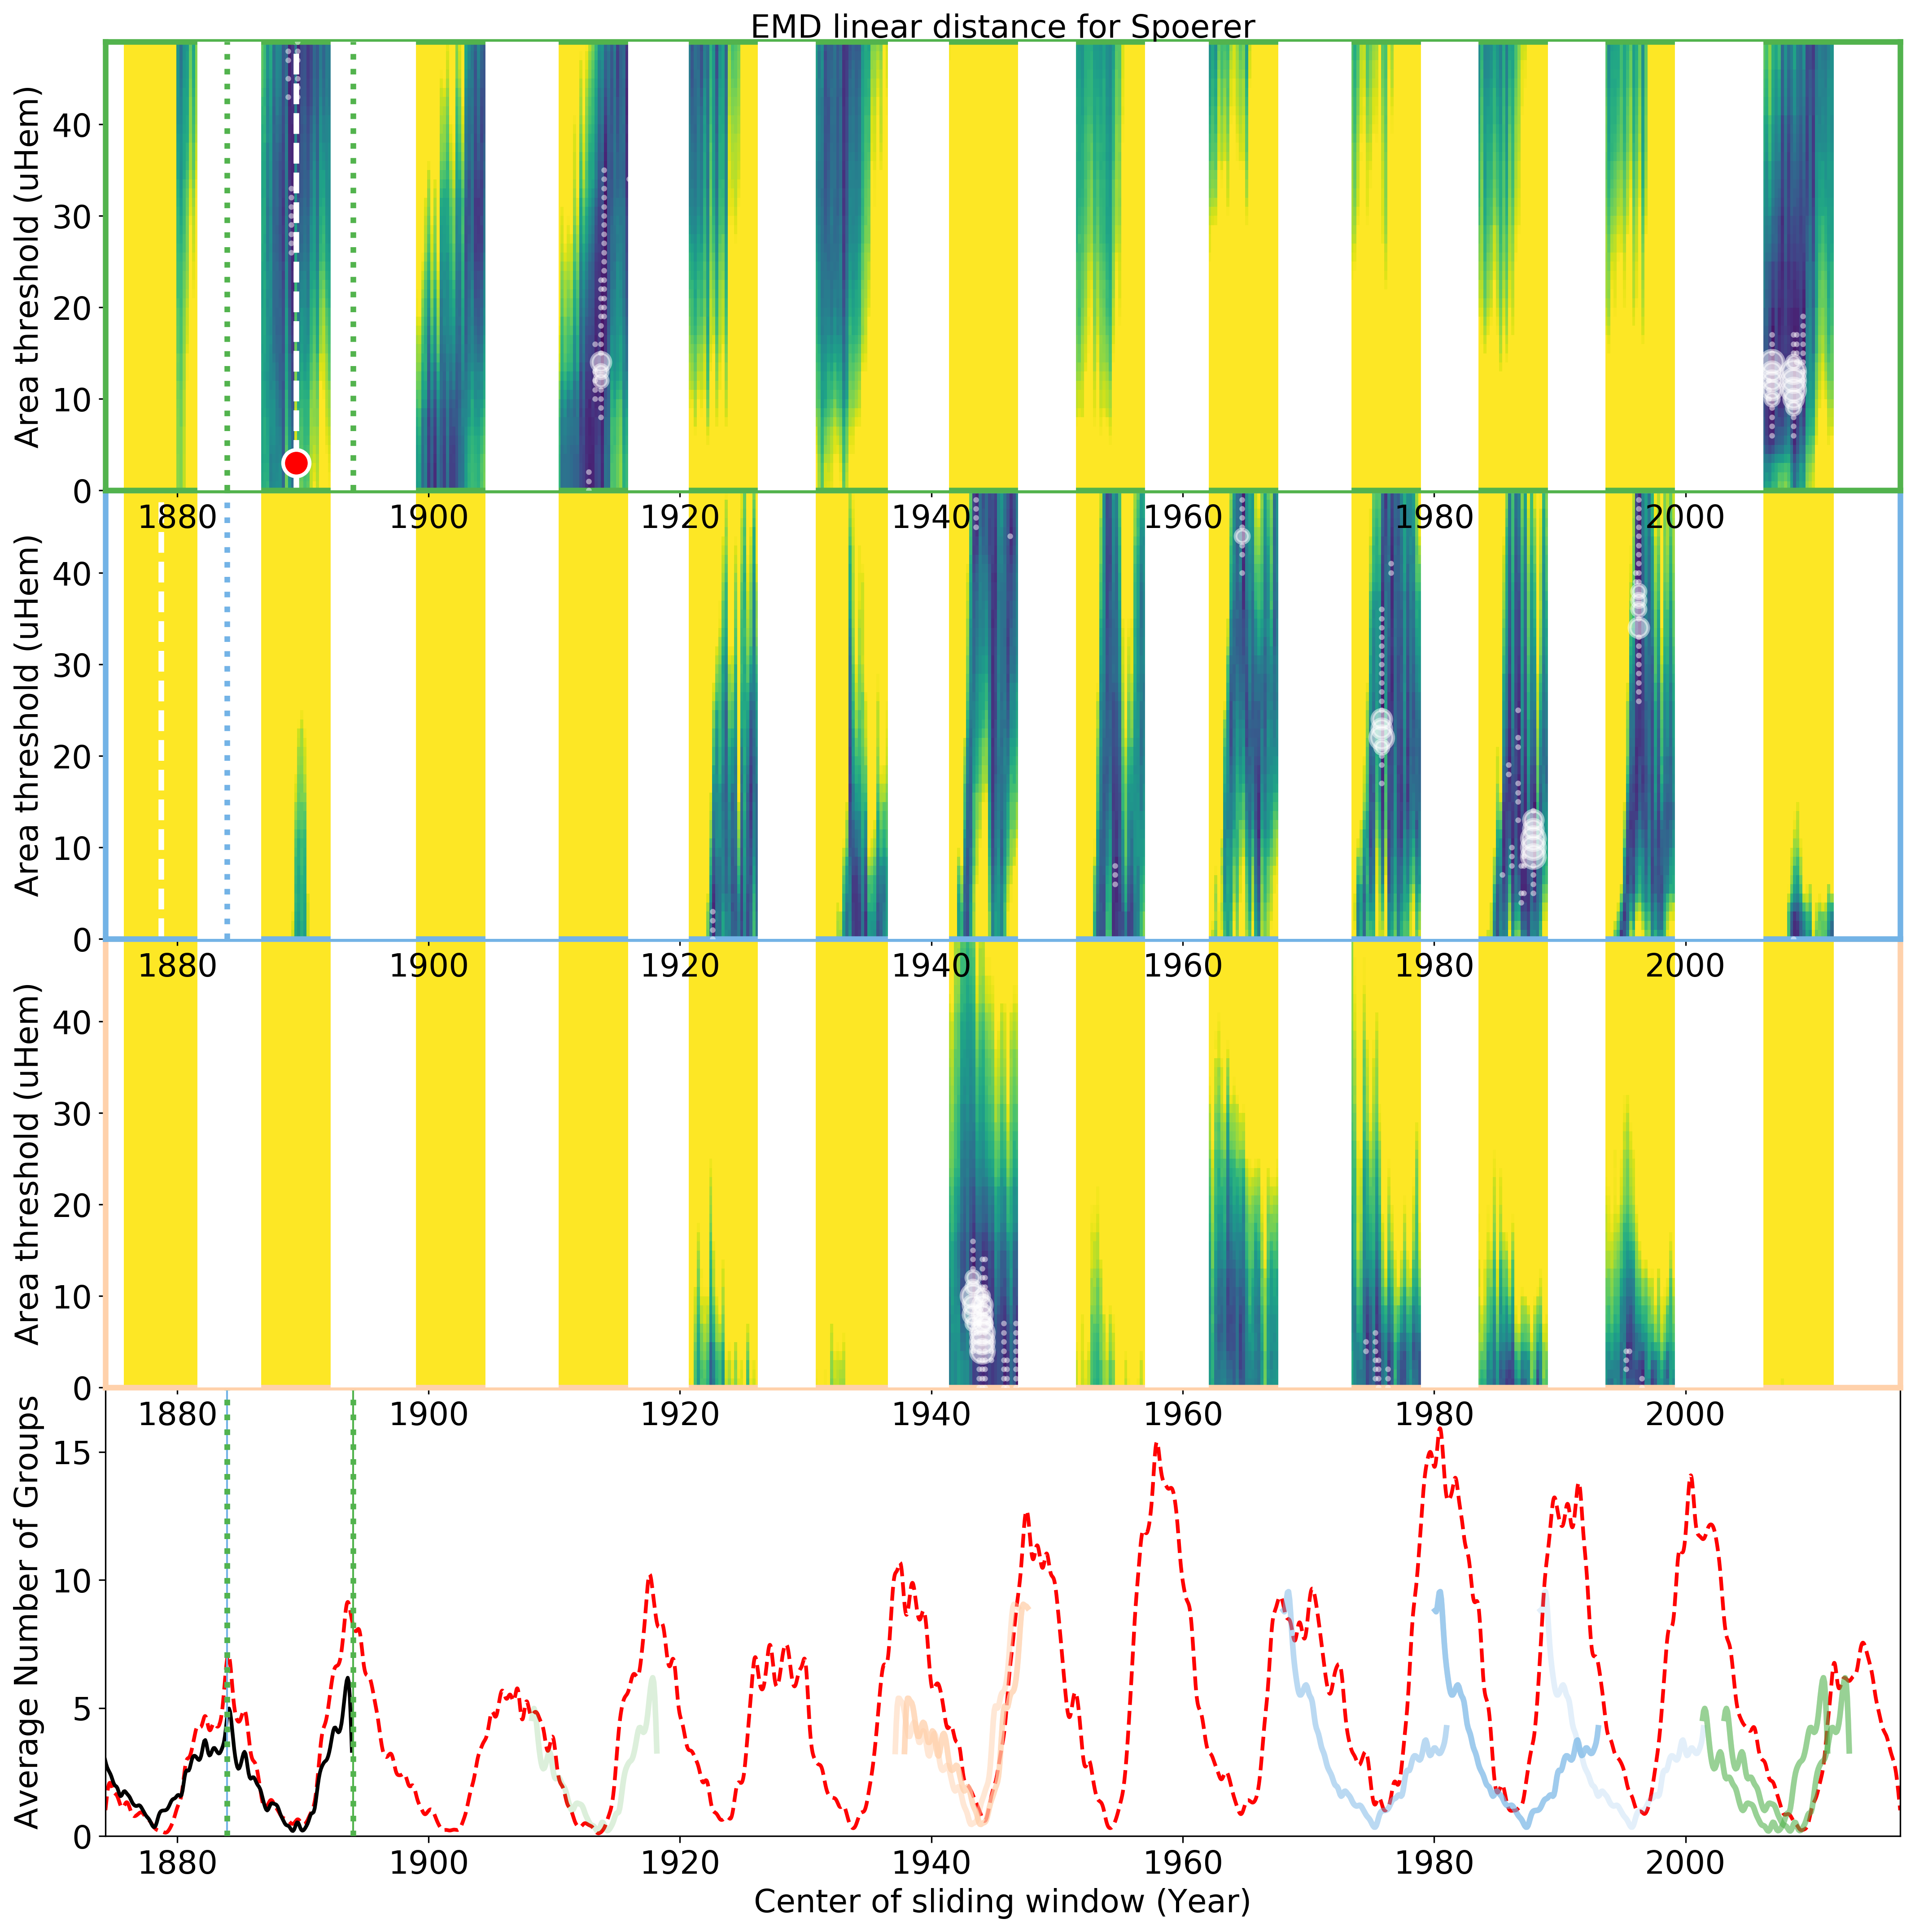

In [17]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel

nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)

# EMD Pcolor
plt.viridis()

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
            
    # Creating matrix for sorting and find the best combinations of threshold and shift
    OpMat = np.concatenate((EMDt[:,:,siInx].reshape((-1,1)),EMDth[:,:,siInx].reshape((-1,1)),EMD[:,:,siInx].reshape((-1,1))), axis = 1)

    # Sort according to EMD to find the best matches
    I = np.argsort(OpMat[:,2],axis = 0)
    OpMat = np.squeeze(OpMat[I,:])

     # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'GROUPS'].values.copy()
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'FRACYEAR'].values.copy()     
    TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'ORDINAL'].values.copy()

    # Find index of minimum inside sub-interval
    minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx]))
    obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx])==minYear).nonzero()[0][0]
    
    #Initialize varialbes to identify the optimum threshold for the period of overlap
    tmpEMD = 1e16
    tmpt   = np.nan
    tmpth  = np.nan
    
    # Calculation of distance matrix to be used in the Earth Movers Metric
    x = np.arange(0,GDREFI[siInx].shape[2])
    y = np.arange(0,GDREFI[siInx].shape[2])
    xx, yy = np.meshgrid(x, y)
    Dis = np.absolute(np.power(xx-yy,1))    
    
    # Calculate optimum threshold for real period of overlap if it exists
    for minT in REF_minT[0:REF_minT.shape[0]-1]:     
        
        # Check if real if interval is present in minima
        if (TObsFYr[obsMinInx] > minT-phTol) and (TObsFYr[obsMinInx] < minT+phTol):      
                        
            # Check if first element is present in reference
            if np.any(REF_Dat['ORDINAL']==TObsOrd[0]):
            
                # Selecting the maximum integer amount of "months" out of the original data
                TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

                #Calculating bracketing indices
                Idx1 =  (REF_Dat['ORDINAL']==TObsOrd[0]).nonzero()[0][0]
                Idx2 = Idx1 + TgrpsOb.shape[0]
   
                # Going through different thresholds
                for TIdx in range(0,thN):

                    # Calculating number of groups in reference data for given threshold
                    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],TIdx*thI) ,axis = 1).astype(float)
                    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan                    

                    # Selecting the maximum integer amount of "months" out of the original data
                    TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

                    #Selecting reference window of matching size to observer sub-interval;
                    TgrpsREF = grpsREFw[Idx1:Idx2].copy()                

                    # Reshaping into "months"
                    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            
                    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))

                    # Imprinting missing days
                    # OBSERVER
                    TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                    # REFERENCE
                    TgrpsREF[np.isnan(TgrpsOb)] = np.nan

                    # Number of days with groups
                    # OBSERVER
                    GDObsT = np.sum(np.greater(TgrpsOb,0),axis=1)
                    # REFERENCE
                    GDREFT = np.sum(np.greater(TgrpsREF,0),axis=1)

                    # Number of days with observations
                    # OBSERVER
                    ODObsT = np.sum(np.isfinite(TgrpsOb),axis=1)
                    # REFERENCE
                    ODREFT = np.sum(np.isfinite(TgrpsREF),axis=1)


                    # Calculating Earth Mover's Distance
                    ADFObs, bins = np.histogram(GDObsT[ODObsT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    ADFREF, bins = np.histogram(GDREFT[ODREFT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    tmp = emd(ADFREF.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))

#                     #Calculating Chi-Square distance
#                     ADFObs, bins = np.histogram(GDObsT[ODObsT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)
#                     ADFREF, bins = np.histogram(GDREFT[ODREFT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)

#                     # Calculating numerator and denominator for Chi-square distance
#                     Nom = np.power(ADFObs-ADFREF,2)
#                     #Den = np.power(ADFObs,2) + np.power(ADFREF,2)
#                     Den = ADFObs + ADFREF

#                     # Removing zeros in denominator
#                     Nom = Nom[Den!=0]
#                     Den = Den[Den!=0]

#                     # Calculating Chi-square distance
#                     tmp = np.sum(np.divide(Nom,Den))

                    # Udating variables
                    if tmp<tmpEMD:
                        tmpEMD = tmp
                        tmpt   = TObsFYr[obsMinInx]
                        tmpth  = TIdx*thI


    OpMat = np.insert(OpMat,0,[tmpt,tmpth,tmpEMD],axis=0)            
            

    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])

    # Calculating mesh for plotting
    x = REF_Grp['FRACYEAR'].values[cadMaskI]
    y = np.arange(0,thN)*thI
    xx, yy = np.meshgrid(x, y)             
    
    #Plotting Optimization Matrix
    mesh = ax1.pcolormesh(xx,yy,EMD[:,:,siInx], alpha = 1, linewidth = 2, vmin = np.min(EMD[:,:,siInx]), vmax = 6*np.min(EMD[:,:,siInx]))
    
    # Masking gaps
    for minT in REF_minT[0:REF_minT.shape[0]-1]:
        
        # Finding the last index in each interval
        IIdx = np.logical_and(x>=minT-phTol,x<=minT+phTol).nonzero()[0]
        
        ax1.fill(np.array([x[IIdx[IIdx.shape[0]-1]], x[IIdx[IIdx.shape[0]-1]], x[IIdx[IIdx.shape[0]-1]+1], x[IIdx[IIdx.shape[0]-1]+1]])
                 , np.array([0, np.max(y), np.max(y), 0]),  color = 'w', zorder=10)
        
    # Plotting real location
    ax1.plot(np.array([1,1])*TObsFYr[obsMinInx], np.array([0,np.max(y)]),'w--', linewidth = 3)
    
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    
    
    
    # True Interval
    ax1.scatter(OpMat[0,0], OpMat[0,1], c = 'r', edgecolors = 'w',linewidths = 2, s = 200, zorder=11)
        
    # Best 5 points
    for i in range(1,5):
        ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 150, zorder=11, alpha = 0.5)
        ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx]+OpMat[i,0]
                 , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                 , alpha = 0.2)

    # Best 5-10 points
    for i in range(5,10):
        ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 100, zorder=11, alpha = 0.5)
        ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx]+OpMat[i,0]
                 , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                 , alpha = 0.2)
        
    # Best 10-15 points
    for i in range(10,15):
        ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 50, zorder=11, alpha = 0.5)

    # Best 15-20 points
    for i in range(15,100):
        ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 1, zorder=11, alpha = 0.5)
        
    # Axes properties
    ax1.set_ylabel('Area threshold (uHem)')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.max(y))
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

fig.savefig(NamObs.capitalize() + '_EMD_1.png', bbox_inches='tight', dpi = 103, pad_inches=0)

**FIGURE:** _Bottom:_ Reference average number of groups (red). True location of the observer groups (black).  Observer sub-intervals (vertical dotted lines).  Top-ten shifts with the best match between observer and reference ADFs (faint colored curves).  Each sub-interval is color coded.

_Top panels:_ Each panel shows the distance measured between observer and reference ADFs as a function of threshold and shift for a given sub-interval. The true location of the sub-interval is shown using colored vertical dotted lines.  The true shift is indicated by a vertical white dashed line.  The optimal threshold for the true interval is shown with a red dot.  The best 20 points are denoted by white circles (the smaller the distance, the larger the dot).  In the colormap, dark blue denotes a good match and bright yellow a bad match.  The color-scale is saturated at 6 times the minimum ADF distance


# Simultaneous Optimization of Thresholds for All Sub-Intervals

The reason behind the division of the observer in sub-intervals is to allow for sequences combining cycles of various strengths that may have been observed outside the reference period, but not in the last 100 years.  However, fitting each sub-interval separately suffers from reduced statistics.  To address that, we perform simultaneous fits for all sub-interval by specifying a threshold, but letting each sub-interval's shift be freely optimized.  


## Calculating the minimum distance for each sub-interval and each shift to identify shifts we could ignore

Using combinations of all possible shifts results in a large, unmanageable, amount of possibilities.  For this reason, for each sub-interval we limit the search to their best shifts defined using the minimum distance for each shift including all thresholds and capped at _disThres_ times the best distance for each sub-interval (see below)  

Number of valid combinations: 48708


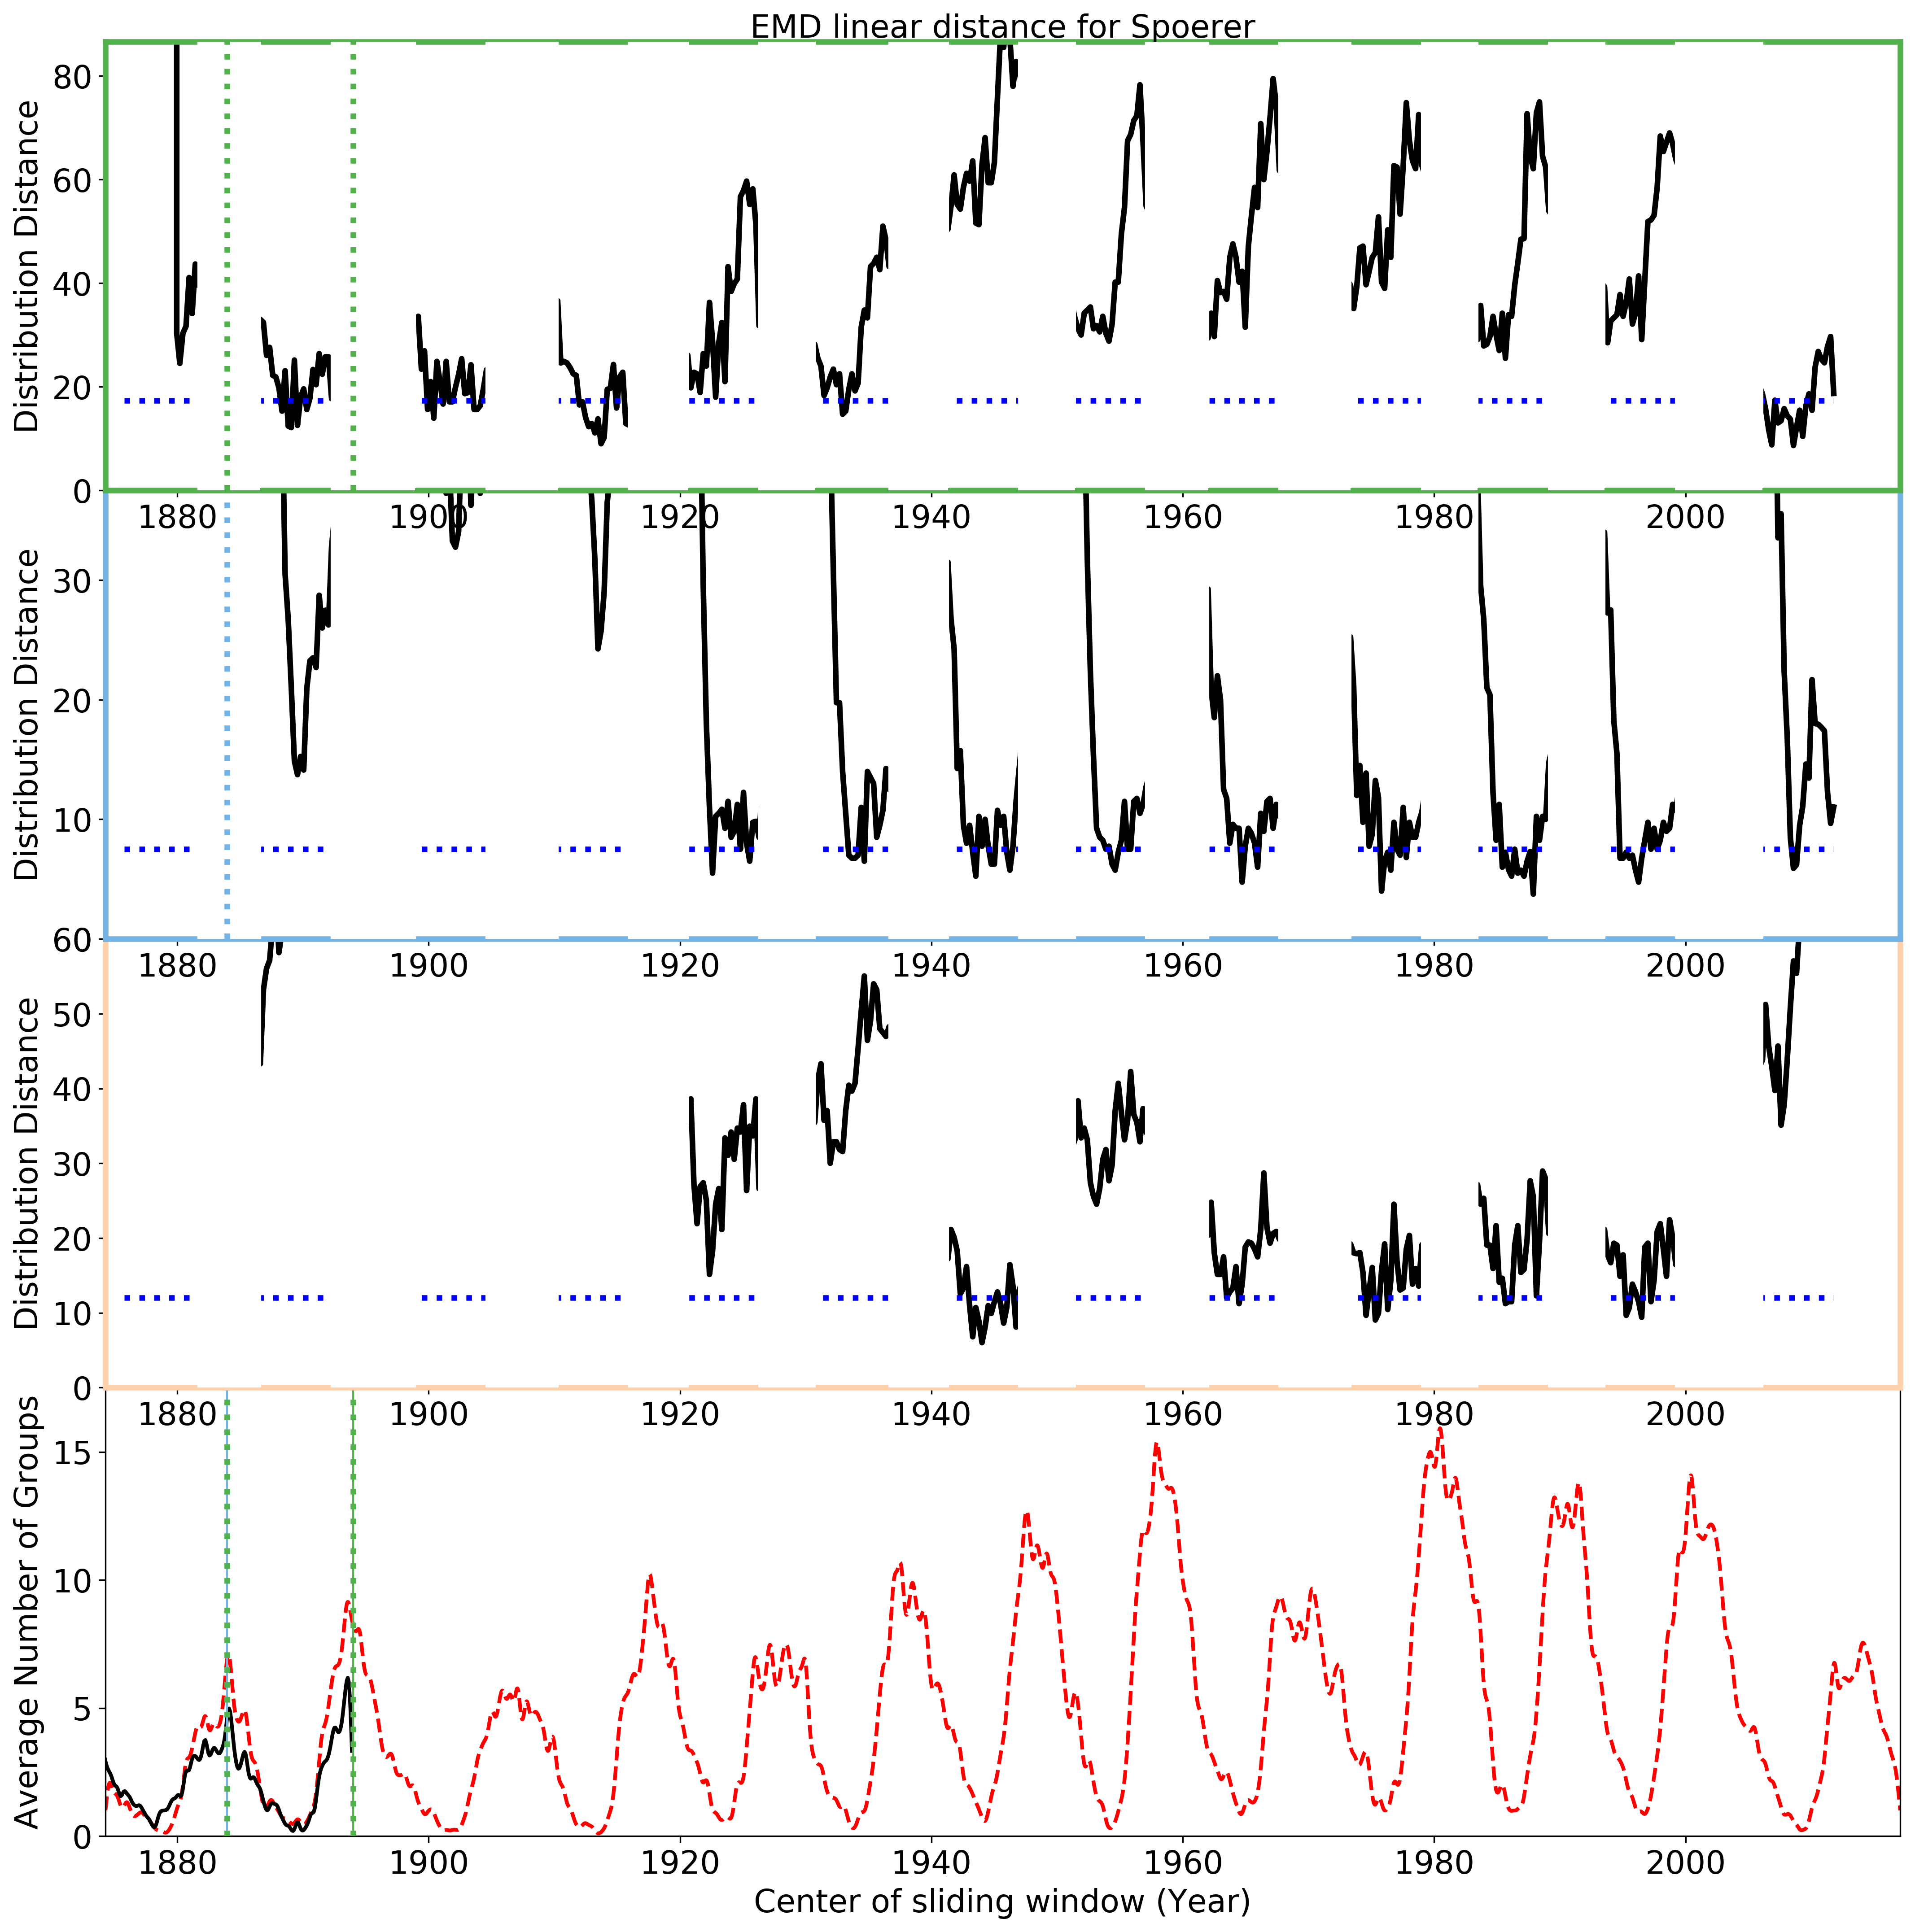

In [18]:
# Threshold above which we will ignore timeshifts (in units of the shortest 
# distance between observer and reference ADFs for each sub-interval separately)
disThres = 2

# Dictionary that will store valid shift indices for each sub-interval
valShfInx = []

# Dictionary that will store the length of the index array for each sub-interval
valShfLen = []

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel

nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'FRACYEAR'].values.copy()         
            
    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])

    # Calculating minimum distance for plotting
    x = REF_Grp['FRACYEAR'].values[cadMaskI]
    y = np.amin(EMD[:,:,siInx],axis=0)
    
    # Appending valid indices to variable and storing length
    valShfInx.append((y<=disThres*np.min(y)).nonzero()[0])
    valShfLen.append(valShfInx[siInx].shape[0])
    
    # Plotting Optimization Matrix
    ax1.plot(x,y, color = 'k', linewidth = 3)
    
    # Plotting possible theshold
    ax1.plot(np.array([np.min(x),np.max(x)]),np.array([1,1])*disThres*np.min(y), 'b:', linewidth = 3)
    
    # Masking gaps
    for minT in REF_minT[0:REF_minT.shape[0]-1]:
        
        # Finding the last index in each interval
        IIdx = np.logical_and(x>=minT-phTol,x<=minT+phTol).nonzero()[0]
        
        ax1.fill(np.array([x[IIdx[IIdx.shape[0]-1]], x[IIdx[IIdx.shape[0]-1]], x[IIdx[IIdx.shape[0]-1]+1], x[IIdx[IIdx.shape[0]-1]+1]])
                 , np.array([0, np.max(y), np.max(y), 0]),  color = 'w', zorder=10)
        
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])        
    
    # Axes properties
    ax1.set_ylabel('Distribution Distance')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.min(y)*10)
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

# Saving lengths as array
valShfLen = np.array(valShfLen)

print('Number of valid combinations:', np.prod(valShfLen))

## Defining Functions to Iterate Over All Possible Combinations

In [19]:
from copy import copy

def mrange(min_values, max_values=None):
    '''
        Inputs: min_values, a list/tuple with the starting values
                    if not given, assumed to be zero
                max_values: a list/tuple with the ending values
        outputs: a tuple of values
    '''
    
    if not max_values:
        max_values = min_values
        min_values = [0 for i in max_values]
    indices_list = copy(min_values)

    #Yield the (0,0, ..,0) value
    yield tuple(indices_list)
    
    while(True):
        indices_list = updateIndices(indices_list, min_values, max_values)
        if indices_list:
            yield tuple(indices_list)
        else:
            break#We're back at the beginning
   
def updateIndices(indices_list, min_values, max_values):
    '''
        Update the list of indices
    '''
    for index in range(len(indices_list)-1, -1, -1):
        
        #If the indices equals the max values, the reset it and 
        #move onto the next value
        if not indices_list[index] == max_values[index] - 1:
            indices_list[index] += 1
            return indices_list
        else:
            indices_list[index] = min_values[index]
    return False

## Doing simultaneous fitting of all intervals by prescribing a common threshold but allowing for any combination of shifts

In order to keep memory requirements manageable we only keep the top _nBest_ matches. 

In [20]:
# Number of top best matches to keep
nBest = 100

# Allocating variable to store top matches
EMDComb = np.ones((cenPoints.shape[0]+2,nBest))*10000

print('start', datetime.datetime.now())

comProg = 0
for comb in mrange(valShfLen):
    
    # Inform user of progress
    if comb[0]!=comProg:
        print(comb[0], 'of', valShfLen[0]-1, 'at', datetime.datetime.now())
        comProg = comb[0]
        
        
    # Going through different thresholds for a given combination of shifts
    for TIdx in range(0,thN):
        
        # Initializing arrays for joining the ADFs of all sub-intervals
        ADFObsI = GDObsI[0][TIdx,valShfInx[0][comb[0]],ODObsI[0][TIdx,valShfInx[0][comb[0]],:]/MoLngt>=minObD]/MoLngt
        ADFREFI = GDREFI[0][TIdx,valShfInx[0][comb[0]],ODREFI[0][TIdx,valShfInx[0][comb[0]],:]/MoLngt>=minObD]/MoLngt
        
        # Joining ADF from all sub-interval for the specified shifts
        if cenPoints.shape[0]>1:
            for siInx in range(1,cenPoints.shape[0]):
                ADFObsI = np.append(ADFObsI, GDObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]/MoLngt)
                ADFREFI = np.append(ADFREFI, GDREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]/MoLngt)

        # Calculating Earth Mover's Distance
        ADFObs, bins = np.histogram(ADFObsI, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ADFREF, bins = np.histogram(ADFREFI, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        tmpEMD = emd(ADFREF.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))
        
        if np.any(EMDComb[0,:]>tmpEMD):
            
            # Determining index for insertion
            insInx = nBest-np.sum(EMDComb[0,:]>=tmpEMD)
            
            # Initializing array to be inserted
            insArr = [tmpEMD,TIdx]
            
            # Append shifts
            for siInx in range(0,cenPoints.shape[0]):
                insArr.append(valShfInx[siInx][comb[siInx]])
            
            # Convert to numpy array
            insArr = np.array(insArr)
            
            # Insert values
            EMDComb = np.insert(EMDComb, insInx, insArr, axis=1)
            
            # Remove last element
            EMDComb = EMDComb[:,0:nBest]

start 2017-11-09 10:52:08.537645
1 of 26 at 2017-11-09 10:56:22.560899
2 of 26 at 2017-11-09 11:00:25.141155
3 of 26 at 2017-11-09 11:04:28.538384
4 of 26 at 2017-11-09 11:08:30.290644
5 of 26 at 2017-11-09 11:12:26.219284
6 of 26 at 2017-11-09 11:16:14.359148
7 of 26 at 2017-11-09 11:19:59.837743
8 of 26 at 2017-11-09 11:23:47.529527
9 of 26 at 2017-11-09 11:27:36.114458
10 of 26 at 2017-11-09 11:31:30.296036
11 of 26 at 2017-11-09 11:35:26.289706
12 of 26 at 2017-11-09 11:39:20.765051
13 of 26 at 2017-11-09 11:43:15.176506
14 of 26 at 2017-11-09 11:47:15.855737
15 of 26 at 2017-11-09 11:51:17.766672
16 of 26 at 2017-11-09 11:55:14.430523
17 of 26 at 2017-11-09 11:59:07.435701
18 of 26 at 2017-11-09 12:03:00.084958
19 of 26 at 2017-11-09 12:06:53.348608
20 of 26 at 2017-11-09 12:10:47.890037
21 of 26 at 2017-11-09 12:14:40.886852
22 of 26 at 2017-11-09 12:18:33.069027
23 of 26 at 2017-11-09 12:22:27.623358
24 of 26 at 2017-11-09 12:26:18.661556
25 of 26 at 2017-11-09 12:30:15.523670
2

## Plot Location and Threshold of Best Matches

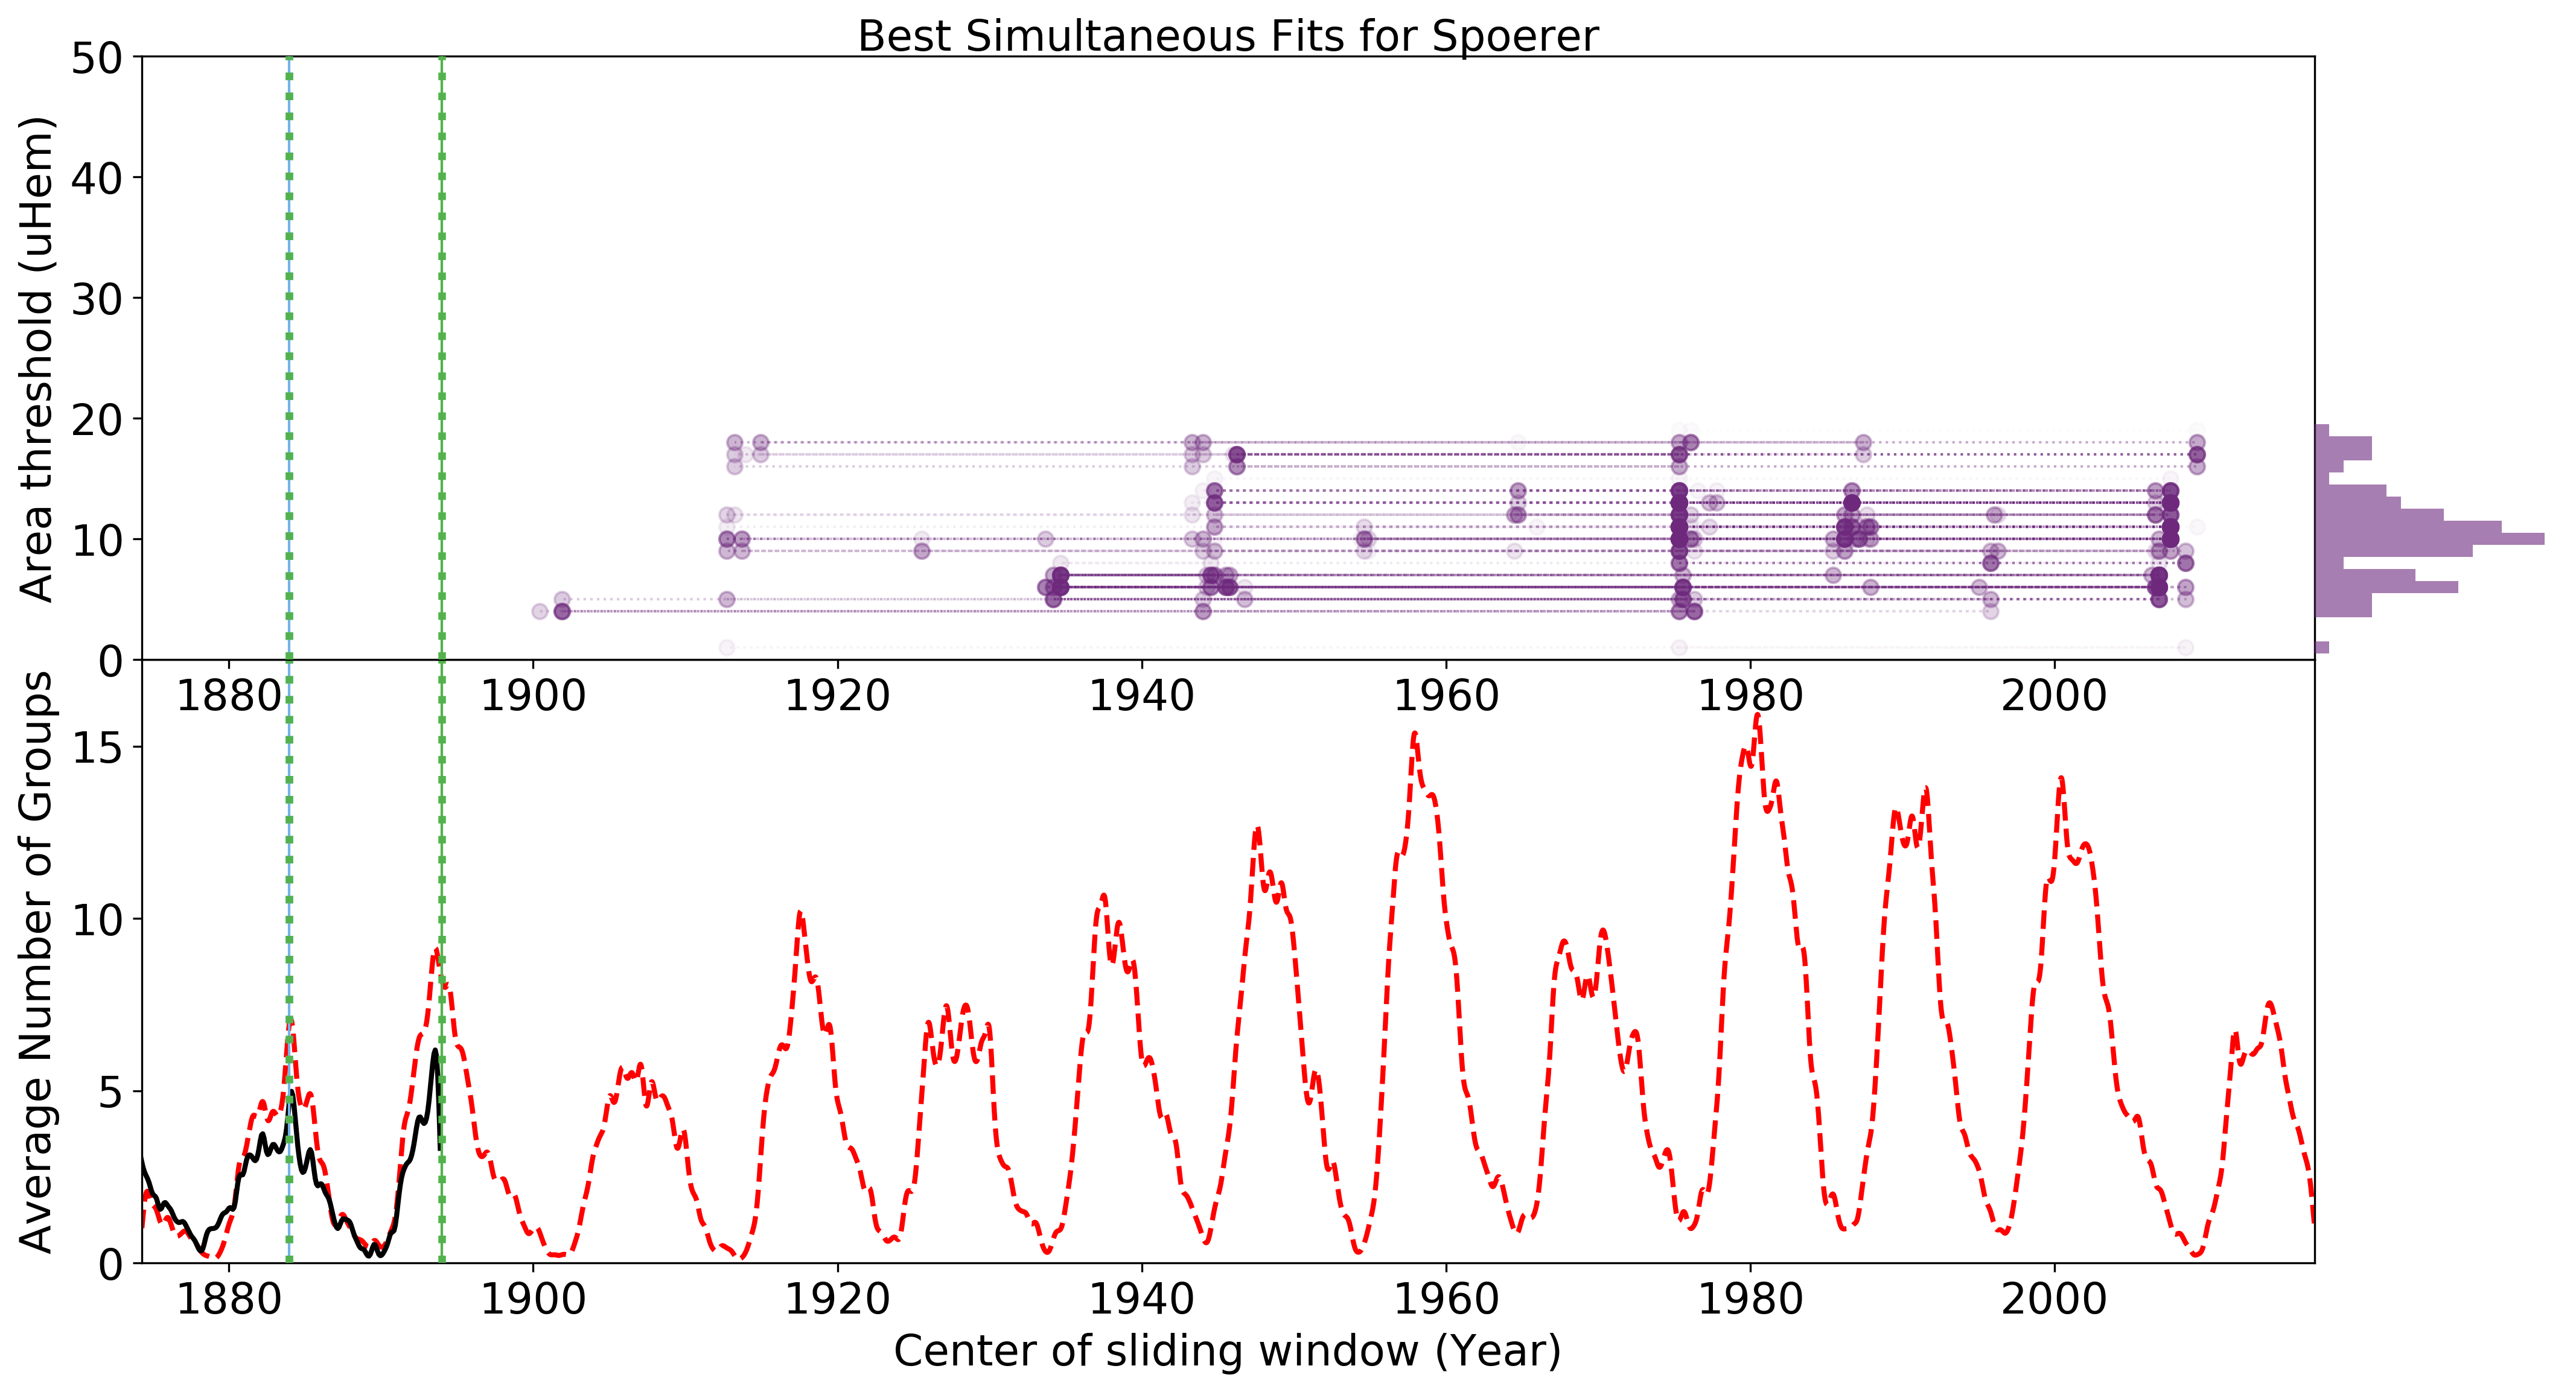

In [21]:
# Threshold above which we will ignore timeshifts (in units of the shortest 
# distance between observer and reference ADFs for each sub-interval separately)
disThres = 4

# Dictionary that will store valid shift indices for each sub-interval
valShfInx = []

# Dictionary that will store the length of the index array for each sub-interval
valShfLen = []

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel
frc = 0.9    # Fraction of the panel devoted to histogram

nph = 1                       # Number of horizontal panels
npv = 2    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)

# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Placement of top simultaneous fits
ax1 = fig.add_axes([ppadh, ppadv + (pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv])


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx],ObsDat['FRACYEAR']<endPoints[siInx+1])
                         ,'FRACYEAR'].values.copy()         
    
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    
# Define years for plotting
Year = REF_Grp['FRACYEAR'].values[cadMaskI]

for i in range(0,nBest):
    
    # Initialize plot vector
    x = [Year[EMDComb[2,i].astype(np.int)]]
    
    # Append other sub-intervals
    if cenPoints.shape[0]>1:
        for siInx in range(1,cenPoints.shape[0]):
            
            x.append(Year[EMDComb[siInx+2,i].astype(np.int)])
            
    # Turning into numpy array
    x = np.array(x)
    
    # Creating matching threshold vector
    y = x*0 + EMDComb[1,i]
    
    # Constructing alpha
    alph = 1-(EMDComb[0,i]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))
      
    # Plotting Intervals
    ax1.plot(x, y,'o:', zorder=11, linewidth = 1, color = Clr[2], alpha = alph)
    
# Axes properties
ax1.set_ylabel('Area threshold (uHem)')
ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
ax1.set_ylim(bottom = 0, top = thN*thI)
    
ax1.text(0.5, 1.01,'Best Simultaneous Fits for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes);


# Right Distribution
ax3 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv + (pxy/fszv+ppadv2), pxx/fszh*(1-frc), pxy/fszv])
ax3.hist(EMDComb[1,:], bins = np.arange(0,thN)*thI+thI/2,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);
# ax3.plot(yOD, xOD, color=Clr[2], linewidth=3)

# # Axes properties
ax3.set_ylim(bottom = 0, top = thN*thI)
ax3.set_axis_off()

fig.savefig(NamObs.capitalize() + '_Simultaneous_Fit_EMD.png', bbox_inches='tight', dpi = 103, pad_inches=0)

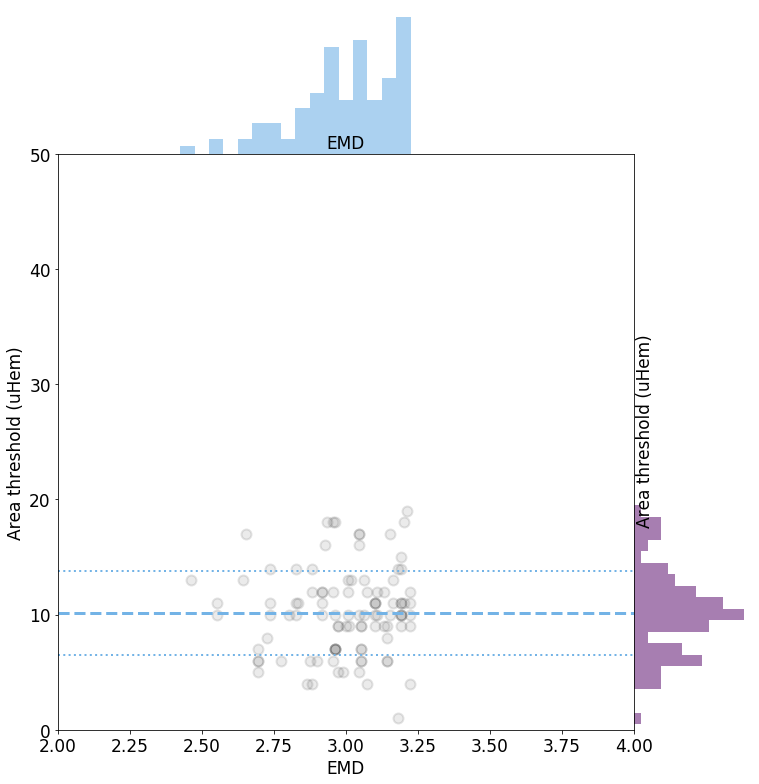

In [23]:
# Distribution Plots of threshold and distance

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
axd.hist(EMDComb[0,:], bins= (np.arange(0,42)-0.5)/40*(np.ceil(np.max(EMDComb[0,:]))-np.floor(np.min(EMDComb[0,:])))
         +np.floor(np.min(EMDComb[0,:])),  color=Clr[4], alpha=.6, normed = True);

# Axes properties
axd.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
axd.set_axis_off()


# Right Distribution
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
ax2.hist(EMDComb[1,:], bins = np.arange(0,thN)*thI+thI/2,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);
# ax2.plot(yOD, xOD, color=Clr[2], linewidth=3)

# # Axes properties
ax2.set_ylim(bottom = 0, top = thN*thI)
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
ax1.scatter(EMDComb[0,:], EMDComb[1,:], color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

# Constructing weights
alph = 1-(EMDComb[0,:]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))

# Weighted average
wAv = np.sum(np.multiply(alph,EMDComb[1,:]))/np.sum(alph)

# Weighted Standard Deviation
wSD = np.sqrt(np.sum(np.multiply(alph,np.power(EMDComb[1,:]-wAv,2)))/np.sum(alph))

ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv, '--'
         , color = Clr[4], linewidth = 3)
ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv-wSD, ':'
         , color = Clr[4], linewidth = 2)
ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv+wSD, ':'
         , color = Clr[4], linewidth = 2)

# Axes properties
ax1.set_ylabel('Area threshold (uHem)')
ax1.text(1.02, 0.52,'Area threshold (uHem)', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('EMD')
ax1.text(0.5, 1.01,'EMD', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
ax1.set_ylim(bottom = 0, top = thN*thI);
